# Content 
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Tokenization](#Tokenization)
- [Model](#Model)
- [Tuning Parameter by CV](#Tuning-Parameter-by-CV)
- [Model Evaluation](#Model-Evaluation)
- [Prediction](#Prediction)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_ks_statistic

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
data = pd.read_csv('../../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
data.shape

(7613, 4)

In [4]:
data.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

# Exploratory Data Analysis

In [5]:
data['keyword'].value_counts()
# maybe just use the levels that have frequency over 30

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
data['keyword'].value_counts()[data['keyword'].value_counts()>= 30]

fatalities      45
deluge          42
armageddon      42
body%20bags     41
harm            41
                ..
survivors       30
avalanche       30
mayhem          30
dead            30
bioterrorism    30
Name: keyword, Length: 200, dtype: int64

In [7]:
keyword_30 = data['keyword'].value_counts()[data['keyword'].value_counts()< 30].index.tolist()
keyword_30
# Filter the frequency less than 40

['seismic',
 'obliteration',
 'sirens',
 'first%20responders',
 'snowstorm',
 'desolate',
 'annihilation',
 'bombing',
 'rubble',
 'demolished',
 'deluged',
 'volcano',
 'battle',
 'bush%20fires',
 'war%20zone',
 'rescue',
 'forest%20fire',
 'epicentre',
 'threat',
 'inundation',
 'radiation%20emergency']

In [8]:
print('keyword:', data.dropna(subset = ['keyword']).iloc[1, 0])
print('location:', data.dropna(subset = ['keyword']).iloc[1, 1])
print('text:', data.dropna(subset = ['keyword']).iloc[1, 2])
# keyword and location may not be mentioned in the text

keyword: ablaze
location: Est. September 2012 - Bristol
text: We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw


In [9]:
data['location'].value_counts()
# too much level

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Lake Monticello, VA              1
Brentwood, NY                    1
North                            1
Where I Need To Be               1
Kalimantan Timur, Indonesia      1
Name: location, Length: 3341, dtype: int64

In [10]:
for i in range(10):
    print(i, data.iloc[i, 2])

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...


In [11]:
data['target'].value_counts()
# A bit unbalanced

0    4342
1    3271
Name: target, dtype: int64

# Data Preprocessing

In [12]:
data_rescale = data.copy()

In [13]:
data_rescale['location'] = 1 - data['location'].isna()
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
data_rescale['location'].value_counts()

1    5080
0    2533
Name: location, dtype: int64

In [15]:
data_rescale['keyword'] = data['keyword'].replace(keyword_30, ['Others'] * len(keyword_30))
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
data_rescale['keyword'] = data_rescale['keyword'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,0,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,0,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,0,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,0,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,0,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
data_rescale['keyword'].value_counts()

Others           500
Not mentioned     61
fatalities        45
deluge            42
armageddon        42
                ... 
mayhem            30
survivors         30
dead              30
avalanche         30
catastrophic      30
Name: keyword, Length: 202, dtype: int64

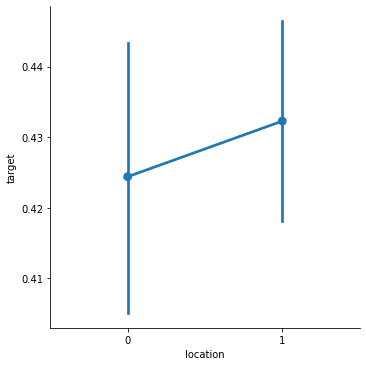

In [18]:
sns.factorplot(data = data_rescale, x = 'location', y = 'target')
plt.show()

In [19]:
chi2_contingency(pd.crosstab(data_rescale['location'], data_rescale['target']), correction=False)
# Independent

(0.42888885897570894,
 0.5125346724399973,
 1,
 array([[1444.6717457, 1088.3282543],
        [2897.3282543, 2182.6717457]]))

In [20]:
chi2_contingency(pd.crosstab(data_rescale['keyword'], data_rescale['target']), correction=False)[1]
# Not independent

0.0

In [21]:
data_rescale = data_rescale.drop(columns = 'location')

In [22]:
train, test = train_test_split(data_rescale, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 3), (2284, 3))

# Model

## One Hot Encoding

In [23]:
onehot = OneHotEncoder(handle_unknown = 'ignore').fit(train['keyword'].values.reshape(-1, 1))

## Tokenization

In [24]:
bow = CountVectorizer().fit(train['text'])

## Feature Union

In [25]:
union = FeatureUnion([('onehot', Pipeline([('keyword', FunctionTransformer(func = lambda x: x['keyword'].values.reshape(-1, 1), validate = False)),
                                           ('onehot_transformer', OneHotEncoder(handle_unknown = 'ignore'))])),
                      ('bow', Pipeline([('text', FunctionTransformer(func = lambda x: x['text'], validate = False)),
                                        ('bow_transformer', CountVectorizer())]))]).fit(train.drop(columns = 'target'))

## Multinomial Naive Bayes Classifier

In [26]:
X = train.drop(columns = 'target')
y = train['target']

In [27]:
X.head()

,keyword,text
id,,
686,attack,@blazerfan not everyone can see ignoranceshe i...
6913,mass%20murderer,White people I know you worry tirelessly about...
6066,heat%20wave,Chilli heat wave Doritos never fail!
1441,body%20bagging,@BroseidonRex @dapurplesharpie I skimmed throu...
6365,hostages,#hot C-130 specially modified to land in a st...


In [28]:
model = Pipeline([('transformer', 
                   FeatureUnion([('onehot', Pipeline([('keyword', FunctionTransformer(func = lambda x: x['keyword'].values.reshape(-1, 1), validate = False)),
                                                      ('onehot_transformer', OneHotEncoder(handle_unknown = 'ignore'))])),
                                 ('bow', Pipeline([('text', FunctionTransformer(func = lambda x: x['text'], validate = False)),
                                                   ('bow_transformer', CountVectorizer())]))])),
                  ('model', MultinomialNB())]).fit(X, y)

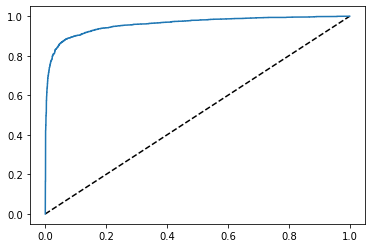

0.9600422375900233


In [29]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

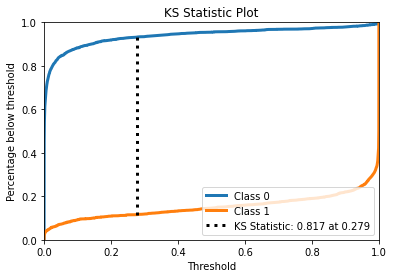

In [30]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

In [31]:
confusion_matrix(y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[2801,  203],
       [ 269, 2056]], dtype=int64)

In [32]:
accuracy_score(y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(X)[:, 1]])

0.9114280352786639

In [33]:
print(cross_val_score(model, X, y, scoring = 'roc_auc', cv=5))
# Overfitting

[0.84190328 0.86249978 0.86086809 0.85107974 0.83396237]


# Tuning Parameter by CV

In [34]:
params = {'transformer__bow__bow_transformer__min_df': [0, 0.05, 0.1, 0.2, 0.5],
          'transformer__bow__bow_transformer__max_features': [1000, 5000, 10000, None],
          'transformer__bow__bow_transformer__ngram_range':[(1, 1), (1, 2), (2, 2)]}
grid = GridSearchCV(model, param_grid = params, cv = 5, scoring = 'roc_auc').fit(X, y)

In [35]:
grid.best_score_

0.8500626500635141

In [36]:
grid.best_params_
# The orignial parameters are the best.

{'transformer__bow__bow_transformer__max_features': None,
 'transformer__bow__bow_transformer__min_df': 0,
 'transformer__bow__bow_transformer__ngram_range': (1, 1)}

# Model Evaluation

In [37]:
test_X = test.drop(columns = 'target')
test_y = test['target']

In [38]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('transformer',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('onehot',
                                                 Pipeline(memory=None,
                                                          steps=[('keyword',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x0000022A5A9BE840>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                        

In [39]:
accuracy_score(y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(X)[:, 1]])

0.9114280352786639

In [40]:
accuracy_score(test_y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(test_X)[:, 1]])

0.7990367775831874

In [41]:
confusion_matrix(y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[2801,  203],
       [ 269, 2056]], dtype=int64)

In [42]:
confusion_matrix(test_y, [1 if prob >= 0.279 else 0 for prob in model.predict_proba(test_X)[:, 1]])

array([[1109,  229],
       [ 230,  716]], dtype=int64)

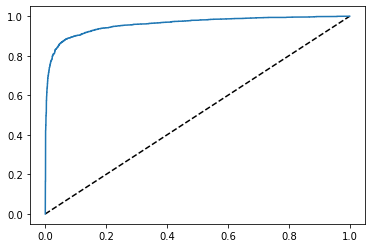

0.9600422375900233


In [43]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

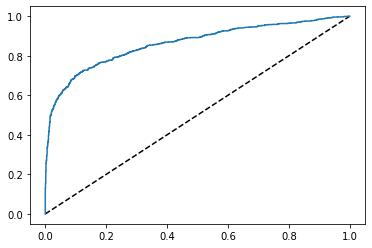

0.8621917632893752


In [44]:
fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

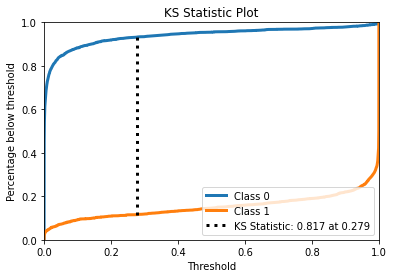

In [45]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

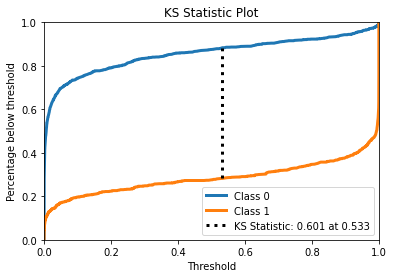

In [46]:
plot_ks_statistic(test_y, model.predict_proba(test_X))
plt.show()

# Prediction

In [47]:
X = data_rescale.drop(columns = 'target')
y = data_rescale['target']

In [48]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('transformer',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('onehot',
                                                 Pipeline(memory=None,
                                                          steps=[('keyword',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x0000022A5A9BE840>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                        

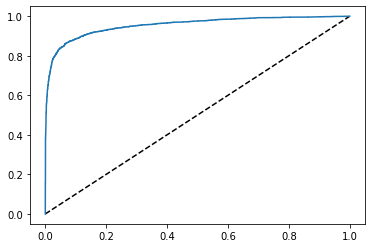

0.9542482891611599


In [49]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

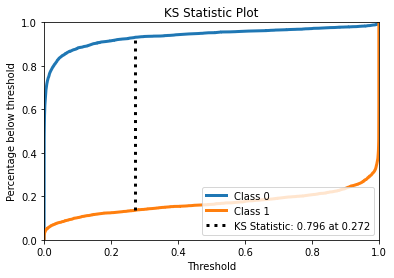

In [50]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

In [51]:
accuracy_score(y, [1 if prob >= 0.272 else 0 for prob in model.predict_proba(X)[:, 1]])

0.9025351372652043

In [52]:
confusion_matrix(y, [1 if prob >= 0.272 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[4043,  299],
       [ 443, 2828]], dtype=int64)

In [53]:
predict = pd.read_csv('../../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [54]:
predict['location'] = 1 - predict['location'].isna()
predict.head()

,keyword,location,text
id,,,
0,NaN,0,Just happened a terrible car crash
2,NaN,0,"Heard about #earthquake is different cities, s..."
3,NaN,0,"there is a forest fire at spot pond, geese are..."
9,NaN,0,Apocalypse lighting. #Spokane #wildfires
11,NaN,0,Typhoon Soudelor kills 28 in China and Taiwan


In [55]:
predict['keyword'] = predict['keyword'].fillna('Not mentioned')
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,0,Just happened a terrible car crash
2,Not mentioned,0,"Heard about #earthquake is different cities, s..."
3,Not mentioned,0,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,0,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,0,Typhoon Soudelor kills 28 in China and Taiwan


In [56]:
predict['keyword'] = predict['keyword'].replace(keyword_30, ['Others'] * len(keyword_30))
predict.head()

,keyword,location,text
id,,,
0,Not mentioned,0,Just happened a terrible car crash
2,Not mentioned,0,"Heard about #earthquake is different cities, s..."
3,Not mentioned,0,"there is a forest fire at spot pond, geese are..."
9,Not mentioned,0,Apocalypse lighting. #Spokane #wildfires
11,Not mentioned,0,Typhoon Soudelor kills 28 in China and Taiwan


In [57]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if prob >= 0.272 else 0 for prob in model.predict_proba(predict.drop(columns = 'location'))[:, 1]]
sample.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [58]:
sample.to_csv('../../data/Disaster/submission.csv')

# Score in Kaggle

0.79252

# Further Work

1. The tokenization takes the most important part in the modelling. We can try different tokenization method, like tf-idf and word2vec.  
2. We converted the location into a dummy variable indicating whether the tweet provided location. But based on Pearson's goodness of fit test on contigency table, it is not significantly dependent to the target. Next time, we can try to select the top n levels from location and group the remaining levels into 'Others'.
3. This time, we only explored multinomial naive Bayes classifier. I think it is not suitable to use the models based on distance measure, like KNN. The data is a mixture of categorical variables and bag of word. It is hard to find a optimal distance function to represent the distance between different observations.